# 1. Setup

## 1.1.Importing and installing the necessary libraries


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 13.8 MB/s 
     |████████████████████████████████| 3.3 MB 31.3 MB/s 
     |████████████████████████████████| 895 kB 36.3 MB/s 
     |████████████████████████████████| 636 kB 46.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install datasets

     |████████████████████████████████| 542 kB 12.8 MB/s 
     |████████████████████████████████| 243 kB 27.9 MB/s 
     |████████████████████████████████| 118 kB 27.8 MB/s 
     |████████████████████████████████| 76 kB 4.2 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
!pip install rouge_score

In [ ]:
# Importing necessary librairies
import datasets
import datetime
from datasets import load_metric
from google.colab import drive
import io
import matplotlib.pyplot as plt
import numpy as np
import pickle 
import pandas as pd
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time
import torch 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from tqdm import tqdm, trange

## 1.2. Importing personal drive to file in order to later load the data and the saved fine tuned model


In [ ]:
# Mount Google Drive to this Notebook instance.
drive.mount('/content/drive')

Mounted at /content/drive


## 1.3. Setting the GPU for training the model 




In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## 2. Load the taining & testing datasets, and the main df to later retrieve reference summaries

In [ ]:
train_dataset = pd.read_csv('/content/drive/MyDrive/Data/train_dataset.csv') #this will be used to train the model
test_dataset = pd.read_csv('/content/drive/MyDrive/Data/test_dataset.csv') #this will be used to generate predictions 
df = pd.read_pickle('/content/drive/MyDrive/Data/SummaDevDocs_preprocessed.pickle') #this will be used to compute the ROUGE scores of the generated summaries 

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. Formatting the data

BERT requires a specific format for its input, namely: 

- Tokenize the sentences at a word level
- Special tokens [CLS] and [SEP] respectively at the begggining and end of each sentence (i.e. input) 
- Map all tokens to their input IDs 
- Pad all sentences for each input to match the same length; the one of the longest sentence. 
- Add Attention mask to differentitate normal tokens from padded tokens.

We implement these pre-processing steps in the below cells. 

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Now computing the longest sentence's length to later pad to that length 
#setting the max length to 0
max_len = 0

#create sentence and label lists from train dataset
sentences = train_dataset.sentence.values
labels = train_dataset.label.values


#for every sentence...
for sent in sentences:

    #tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    #update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

#printing the maximum sentence length. 
print('Max sentence length: ', max_len)

Loading BERT tokenizer...
Max sentence length:  203


Now that we have the maximum sentence length, we can pre-process all the sentences as per defined above. 

We use the encode_plus method of huggingface's BERT tokenizer to carry these steps.

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  This project aims to influence the policy and institutional landscapes within which RE solutions are promoted, deployed, and sustainably supported in the Philippines.  
Token IDs: tensor([  101,  2023,  2622,  8704,  2000,  3747,  1996,  3343,  1998, 12148,
        12793,  2306,  2029,  2128,  7300,  2024,  3755,  1010,  7333,  1010,
         1998, 15770,  8231,  3569,  1999,  1996,  5137,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

## 3.2. Training & Validation Split


We use the dataset library of huggingface to split the already formatted train_dataset into a training and a validation dataset for the training purpose.

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

22,582 training samples
2,510 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an cased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4

In [ ]:
# Setting one hyperparameters' values ; we note that AdamW is a class from Huggingface's library 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run 4 epochs to start with
epochs = 4

# We set the number of total_steps
total_steps = len(train_dataloader) * epochs

# We create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Define a helper function for calculating accuracy.

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Now kicking off the training

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# We set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# We measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # We measure how long the training epoch takes.
    t0 = time.time()

    # We reset the total loss for this epoch.
    total_train_loss = 0

    # We put the model into training mode. 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # We clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()        

        # We store the results in a results object
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # We accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # We perform a backward pass to calculate the gradients.
        loss.backward()

        # We clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # We update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # We update the learning rate.
        scheduler.step()

    # We calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # We measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, wz measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # We put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    706.    Elapsed: 0:01:19.
  Batch    80  of    706.    Elapsed: 0:02:38.
  Batch   120  of    706.    Elapsed: 0:03:58.
  Batch   160  of    706.    Elapsed: 0:05:18.
  Batch   200  of    706.    Elapsed: 0:06:37.
  Batch   240  of    706.    Elapsed: 0:07:57.
  Batch   280  of    706.    Elapsed: 0:09:17.
  Batch   320  of    706.    Elapsed: 0:10:37.
  Batch   360  of    706.    Elapsed: 0:11:56.
  Batch   400  of    706.    Elapsed: 0:13:16.
  Batch   440  of    706.    Elapsed: 0:14:36.
  Batch   480  of    706.    Elapsed: 0:15:56.
  Batch   520  of    706.    Elapsed: 0:17:16.
  Batch   560  of    706.    Elapsed: 0:18:35.
  Batch   600  of    706.    Elapsed: 0:19:55.
  Batch   640  of    706.    Elapsed: 0:21:15.
  Batch   680  of    706.    Elapsed: 0:22:35.

  Average training loss: 0.19
  Training epcoh took: 0:23:26

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.16
  Validation took: 0:00:59

====

Let's view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.19,0.16,0.95,0:23:26,0:00:59
2,0.13,0.17,0.94,0:23:31,0:00:59
3,0.09,0.21,0.95,0:23:18,0:00:58
4,0.06,0.23,0.94,0:23:09,0:00:58


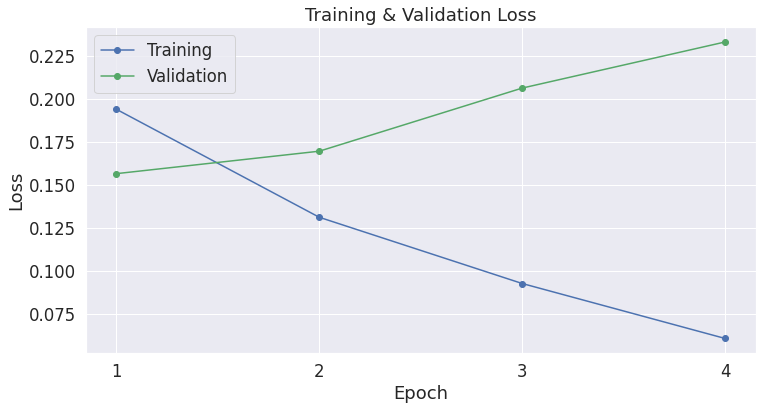

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

First, we compute the test set's longest sentence's length.



In [ ]:
# Now computing the longest sentence's length to later pad to that length 
#setting the max length to 0
max_len = 0

#create sentence and label lists from train dataset
sentences = test_dataset.sentence.values
labels = test_dataset.label.values

#for every sentence...
for sent in sentences:

    #tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    #update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

#printing the maximum sentence length. 
print('Max sentence length: ', max_len)

Max sentence length:  210


Then applying the formatting using the same method as for the train set earlier.

In [ ]:

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_dataset.shape[0]))

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 6,077



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 6,077 test sentences...
    DONE.


## 5.3. Computing the ROUGE metrics to assess the model's performance

### 5.3.1. Formatting the data to allow metric computation

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()


# Adding flat_prediction to the test_datasets
test_dataset['prediction'] = flat_predictions

# Create a new dataframe which groups the predictions based on their document_label to map the prediction to the original text 
df_summaries = test_dataset.groupby('document_label').agg(list)
#resetting the index
df_summaries = df_summaries.reset_index()

# Now we wish to extract the summaries only 
# Keeping the sentences that were predicted with 1
#creating empty lists
predicted_labels, predicted_sentences, actual_labels, actual_sentences, doc_labels =[],[],[],[],[]

#looping in every line of the df_summaries simultaneously 
for predicted_label, predicted_text, actual_label, doc_label in zip(df_summaries['prediction'], 
                                                                    df_summaries['sentence'], 
                                                                    df_summaries['label'], 
                                                                    df_summaries['document_label']):
    #looping in each item of each line of df_summaries
    for pred_label, pred_sent, act_label in zip(predicted_label, 
                                                              predicted_text, 
                                                              actual_label):
        #setting the condition that only if the item equals 1 in the predicted_labels
        #assing the text, the predicted label, the actual label and the document label to the lists 
        if pred_label == 1:
            predicted_labels.append(pred_label)
            predicted_sentences.append(pred_sent)
            actual_labels.append(act_label)
            doc_labels.append(doc_label)

# Creating a new dataframe with only the predicted sentences kept, against the actual label 
df_summaries = pd.DataFrame({'predicted_label': predicted_labels,
                             'predicted_summary': predicted_sentences,
                             'reference_label' : actual_labels,
                             'document_label': doc_labels})

#grouping by the document label and resetting the index 
df_summaries = df_summaries.groupby('document_label').agg(list).reset_index()

# Adding the actual summaries for each document to the dataframe
# This is critical for the evaluation 

#creataing an empty list 
reference_summaries = []

#looping though the document labels in the df_summaries 
for label in df_summaries['document_label']:
  #looping through both the indexes and the text of the original summaries in the initial dataframe
  for index, summ in zip(df.index, df['summary_clean']):
        #setting the condition that if the index of the actual summary in the original document equals 
        #to the label of the document in the results (i.e. summaries) dataframe 
        #append the summary to the empty list
        if label == index:
            reference_summaries.append(summ)

# Adding the list to the df_summaries dataframe
df_summaries['reference_summary'] = reference_summaries



### 5.3.2. Computing ROUGE scores

In [ ]:
# Computing rouge scores for the results 

#load Huggingface's rouge metric 
metric = load_metric("rouge")

#creating empty lists for the predicted and the actual summaries 
predicted_summaries = []
reference_summaries = []

#looping through both the predicted and the actual summaries 
for doc_pred, doc_label in zip(df_summaries['predicted_summary'], df_summaries['reference_summary']):
    #looping through each sentence within the predicted and the actual summaries  
    for pred_summ, labelled_summ in zip(doc_pred, doc_label):
        #appending these to the empty lists 
        predicted_summaries.append(pred_summ)
        reference_summaries.append(labelled_summ)

#computing and saving the rouge scores in rouge_scores object 
rouge_scores = metric.compute(predictions=predicted_summaries, references=reference_summaries)

#printing the scores 
print(rouge_scores)

{'rouge1': AggregateScore(low=Score(precision=0.7910976085318208, recall=0.8595790703168934, fmeasure=0.8073885877951742), mid=Score(precision=0.8171165949092476, recall=0.8829269408794783, fmeasure=0.8338386346609261), high=Score(precision=0.8420221444034007, recall=0.9040700487669173, fmeasure=0.8575905303384435)), 'rouge2': AggregateScore(low=Score(precision=0.757920947115306, recall=0.8143744657842911, fmeasure=0.7746102188017661), mid=Score(precision=0.7873272038389125, recall=0.8429084303813039, fmeasure=0.8032783646158614), high=Score(precision=0.8198210909263816, recall=0.8736833255764689, fmeasure=0.8345649169648197)), 'rougeL': AggregateScore(low=Score(precision=0.780207519748108, recall=0.8458284904162581, fmeasure=0.7981098685966692), mid=Score(precision=0.8066658404135223, recall=0.8698916535577643, fmeasure=0.8230075297365713), high=Score(precision=0.8338079083074963, recall=0.8945449499746657, fmeasure=0.8492418636749738)), 'rougeLsum': AggregateScore(low=Score(precision

### 6. Inspecting a few summaries randomly to assess their quality

In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][2])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][2])

This is the reference summary: 
['Strengthening human rights monitoring in Ethiopia']
This is the predicted summary: 
["AINL/HURICAP's expertise is to train human rights organisations and activists in how to monitor, document and report human rights violations and abuses more effectively, as well as how to use the data collected more effectively in putting pressure on governments as well as onregional and international human rights bodies."]


In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][5])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][5])

This is the reference summary: 
['This Activity aims to sustain and increase electricity demand through demand-side interventions, including support for improved customer service and connection equipment, a consumer education campaign, and improved access to equipment and appliances for customers.']
This is the predicted summary: 
['This Activity aims to sustain and increase electricity demand through demand-side interventions, including support for improved customer service and connection equipment, a consumer education campaign, and improved access to equipment and appliances for customers.']


In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][243])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][243])

This is the reference summary: 
["The development objective of the Managing Natural Hazards Project for Vietnam is to increase the resilience of the people and economic assets to natural hazards in selected river basins of the project provinces within the overall framework of Vietnam's national disaster prevention, response and mitigation strategy towards 2020."]
This is the predicted summary: 
["The development objective of the Managing Natural Hazards Project for Vietnam is to increase the resilience of the people and economic assets to natural hazards in selected river basins of the project provinces within the overall framework of Vietnam's national disaster prevention, response and mitigation strategy towards 2020."]


In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][103])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][103])

This is the reference summary: 
['The objective of the Autonomous Region in Muslim Mindanao (ARMM) Social Fund Project for Philippines is to assist the Borrower to reduce poverty and to support mechanisms for the promotion of a peaceful and safe environment in the conflict-affected areas in the ARMM region']
This is the predicted summary: 
['The objective of the Autonomous Region in Muslim Mindanao (ARMM) Social Fund Project for Philippines is to assist the Borrower to reduce poverty and to support mechanisms for the promotion of a peaceful and safe environment in the conflict-affected areas in the ARMM region and in particular to: (a) improve access to social and economic infrastructure and livelihood opportunities; (b) strengthen social cohesion and partnerships between and within targeted communities; and (c) improve local governance and institutional capacities for implementation in the ARMM region, with a focus on improved participation, transparency and accountability in the allo

In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][109])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][109])

This is the reference summary: 
['The objective of the Cyclone Idai and Kenneth Emergency Recovery and Resilience Project for Mozambique is to support the recovery of public and private infrastructure and livelihoods while strengthening climate resilience in the areas most affected by Cyclones Idai and Kenneth.']
This is the predicted summary: 
['The objective of the Cyclone Idai and Kenneth Emergency Recovery and Resilience Project for Mozambique is to support the recovery of public and private infrastructure and livelihoods while strengthening climate resilience in the areas most affected by Cyclones Idai and Kenneth.']
